### Performs donor-id (not sample) pseudobulking of ATAC-seq peaks

### Test with for one cell type to see if we can obtain differential peaks by age_status and disease_status

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
import os
import pickle

from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats
from pydeseq2.utils import load_example_data

from collections import Counter
from upsetplot import UpSet
from scipy import stats
import gseapy as gp
from gseapy import barplot, dotplot

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import run_pydeseq2_plots as funcs
import time as time

In [24]:
import scanpy as sc
adata = sc.read_h5ad("../07_final_ATAC.h5ad")
adata

AnnData object with n_obs × n_vars = 690044 × 654221
    obs: 'ATAC_barcode', 'sample_id', 'leiden', 'donor_id', 'study', 'age_status', 'age', 'sex', 'region', 'disease_binary', 'technology', 'fragment_file', 'full_path', 'file', 'nfrag', 'tsse', 'cell_type', 'tech_plus_study', 'age_group', 'decade', 'final_cell_type', 'cell_or_nuclei', 'disease'
    var: 'count', 'selected'
    uns: 'age_status_colors', 'cell_type_colors', 'leiden', 'leiden_colors', 'neighbors', 'spectral_eigenvalue', 'study_colors'
    obsm: 'X_spectral', 'X_spectral_harmony', 'X_umap'
    obsp: 'connectivities', 'distances'

In [26]:
adata_metadata = adata.obs

In [29]:
adata_metadata.groupby(["study", "disease_binary"])['ATAC_barcode'].count()

study               disease_binary
Ameen 2022          N                  14107
                    Y                      0
ENCODE v4 (Snyder)  N                 494790
                    Y                      0
Kanemaru 2023       N                  28952
                    Y                      0
Kuppe 2022          N                   6814
                    Y                  27505
Penn                N                 117876
                    Y                      0
Name: ATAC_barcode, dtype: int64

In [2]:
plots_dir = "DEG_contrasts_intersection_plots/"
results_dir = "pydeseq2_results/"
os.makedirs(plots_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

In [3]:
count_matrix_dir="pseudobulked_counts/"

In [4]:
def reformat_contrast_for_results_dict(contrast_name):
    '''
    Reformat a contrast name to the format for extracting it from results_dict
    Example: ("age-group", "fetal", "young") --> ['age-group_fetal_vs_young']
    '''

    factor, group1, group2 = contrast
    formatted_contrast = f"{factor}_{group1}_vs_{group2}"
    return(formatted_contrast)

In [5]:
def plot_DE_genes_barplot(significant_genes_dict, title="Gene expression by contrast"):
    '''
    Plots the number of upregulated and downregulated genes per contrast specified in the results_dict. This should have
    been generated using run_deseq_analysis()
    
    Inputs are: 
    - results_dict: Dictionary with keys as categories and values as dictionaries with 'up' and 'down' gene lists.
    - title: Title of the plot.
    '''
    
    # prepare data for plotting
    categories = list(significant_genes_dict.keys())
    up_counts = [len(significant_genes_dict[cat]['up']) for cat in categories]
    down_counts = [len(significant_genes_dict[cat]['down']) for cat in categories]
    
    # convert this to a dataframe for plotting
    df = pd.DataFrame({'Upregulated': up_counts, 
                       'Downregulated': down_counts}, 
                      index=categories)
    
    # produce the plot
    ax = df.plot(kind='bar', stacked=False, figsize=(10, 6), color=['#1f77b4', '#ff7f0e'])
    ax.set_title(title)
    ax.set_xlabel("Category")
    ax.set_ylabel("Number of DE genes")
    ax.legend(title="Expression direction")
 
    # add values on top of each bar
    for i, (up, down) in enumerate(zip(up_counts, down_counts)):
        ax.text(i - 0.2, up + 50, str(up), color='#1f77b4', ha='center')
        ax.text(i + 0.2, down + 50, str(down), color='#ff7f0e', ha='center')
    
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    return plt

### Load in a count matrix

In [30]:
%%time
cell_type = "Endothelial"
count_matrix, metadata = funcs.load_data(cell_type = cell_type, count_matrix_dir=count_matrix_dir)

CPU times: user 26.4 s, sys: 971 ms, total: 27.3 s
Wall time: 27.7 s


In [31]:
# identify number of fetal donors
num_fetal_donors = metadata[metadata.age_status == "fetal"].shape[0]

# specify the contrasts; if there are not more than 3 fetal donors, then skip that contrast
if num_fetal_donors > 3:
    contrasts = [
        ("age-group", "fetal", "young"),
        ("age-group", "old", "young"),
        ("disease-binary", "Y", "N"),
        ("sex", "male", "female"),
    ]
else:
     contrasts = [
        ("age-group", "old", "young"),
        ("disease-binary", "Y", "N"),
        ("sex", "male", "female"),
    ]

print(contrasts)

[('age-group', 'fetal', 'young'), ('age-group', 'old', 'young'), ('disease-binary', 'Y', 'N'), ('sex', 'male', 'female')]


In [32]:
metadata.head()

,donor_id,age_status,age_group,sex,disease_binary,tech_plus_study,technology,study
0,Ameen 2022:GSM5495102_F6_v2,fetal,fetal,female,N,10X_ATAC_Ameen 2022,10X_ATAC,Ameen 2022
1,Ameen 2022:GSM5495103_F8_v2,fetal,fetal,male,N,10X_ATAC_Ameen 2022,10X_ATAC,Ameen 2022
2,Ameen 2022:GSM5495104_F19_v2,fetal,fetal,female,N,10X_ATAC_Ameen 2022,10X_ATAC,Ameen 2022
3,ENCODE v4 (Snyder):ENCFF069ATM,fetal,fetal,male,N,Multiome-v1_ENCODE v4 (Snyder),Multiome-v1,ENCODE v4 (Snyder)
4,ENCODE v4 (Snyder):ENCFF248EWR,fetal,fetal,male,N,Multiome-v1_ENCODE v4 (Snyder),Multiome-v1,ENCODE v4 (Snyder)


In [33]:
metadata.groupby([ "study", "disease_binary"])['donor_id'].count()

study               disease_binary
Ameen 2022          N                  3
ENCODE v4 (Snyder)  N                 71
Kanemaru 2023       N                  4
Kuppe 2022          N                  4
                    Y                 13
Penn                N                 11
Name: donor_id, dtype: int64

In [34]:
%%time
v1_results_dict, v1_significant_genes, v1_dds = funcs.run_deseq_analysis(count_matrix, metadata, 
                                                                contrasts,
                                                                covariate_keys = ["sex", "age_group", "disease_binary"])

/home/william/anaconda3/envs/r-kernel/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/mnt/data1/william/human_heart_project/Final_manuscript_analysis/ATAC/aggregated_analysis/pseudobulked_analysis/run_pydeseq2_plots.py:118: UserWarning: Same factor names in the design contain underscores ('_'). They will
                be converted to hyphens ('-').
  dds = DeseqDataSet(
Fitting size factors...
... done in 0.87 seconds.

Fitting dispersions...
... done in 26.97 seconds.

Fitting dispersion trend curve...
/home/william/anaconda3/envs/r-kernel/lib/python3.12/site-packages/pydeseq2/dds.py:715: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 2.50 seconds.

Fitting MAP dispersions...
... done in 32.36 seconds.

Fitting LFCs...
...

Log2 fold change & Wald test p-value: age-group fetal vs young
                         baseMean  log2FoldChange     lfcSE      stat  \
chr1:794224-794725       5.207113       -0.118511  0.301104 -0.393590   
chr1:794869-795370      16.681007       -0.577898  0.300119 -1.925560   
chr1:806996-807497       5.363628       -0.988116  0.417642 -2.365938   
chr1:807687-808188       5.803682       -0.226801  0.404657 -0.560476   
chr1:814556-815057       3.749195        0.062251  0.366437  0.169882   
...                           ...             ...       ...       ...   
chrY:20574903-20575404   4.683467        0.082424  0.303904  0.271218   
chrY:21702831-21703332   7.292253       -2.655653  0.444511 -5.974329   
chrY:21705255-21705756   4.760172       -2.284181  0.427445 -5.343797   
chrY:22123981-22124482   4.040439       -1.849674  0.555883 -3.327454   
chrY:22461930-22462431   4.200410       -1.956209  0.559621 -3.495594   

                              pvalue          padj  
chr1:79

Running Wald tests...
... done in 10.68 seconds.



Log2 fold change & Wald test p-value: age-group old vs young
                         baseMean  log2FoldChange     lfcSE      stat  \
chr1:794224-794725       5.207113       -0.248015  0.270630 -0.916435   
chr1:794869-795370      16.681007        0.159399  0.260306  0.612351   
chr1:806996-807497       5.363628        0.160878  0.352969  0.455783   
chr1:807687-808188       5.803682        0.095582  0.355187  0.269103   
chr1:814556-815057       3.749195        0.537050  0.323125  1.662049   
...                           ...             ...       ...       ...   
chrY:20574903-20575404   4.683467       -0.030595  0.248056 -0.123339   
chrY:21702831-21703332   7.292253        0.010055  0.277073  0.036290   
chrY:21705255-21705756   4.760172       -0.115747  0.253015 -0.457470   
chrY:22123981-22124482   4.040439        0.196376  0.409473  0.479583   
chrY:22461930-22462431   4.200410        0.116962  0.412673  0.283426   

                          pvalue      padj  
chr1:794224-79472

Running Wald tests...
... done in 9.66 seconds.



Log2 fold change & Wald test p-value: disease-binary Y vs N
                         baseMean  log2FoldChange     lfcSE      stat  \
chr1:794224-794725       5.207113       -0.928347  0.313671 -2.959621   
chr1:794869-795370      16.681007       -1.564526  0.282575 -5.536676   
chr1:806996-807497       5.363628       -1.902917  0.434630 -4.378249   
chr1:807687-808188       5.803682       -1.358980  0.396442 -3.427942   
chr1:814556-815057       3.749195       -1.498216  0.406914 -3.681896   
...                           ...             ...       ...       ...   
chrY:20574903-20575404   4.683467        0.552109  0.246618  2.238723   
chrY:21702831-21703332   7.292253        0.259727  0.287431  0.903614   
chrY:21705255-21705756   4.760172       -0.095897  0.277837 -0.345157   
chrY:22123981-22124482   4.040439       -1.832606  0.520632 -3.519963   
chrY:22461930-22462431   4.200410       -1.869730  0.524881 -3.562194   

                              pvalue      padj  
chr1:794224-79

Running Wald tests...
... done in 10.03 seconds.



Log2 fold change & Wald test p-value: sex male vs female
                         baseMean  log2FoldChange     lfcSE      stat  \
chr1:794224-794725       5.207113       -0.217554  0.185785 -1.170997   
chr1:794869-795370      16.681007       -0.118785  0.181981 -0.652735   
chr1:806996-807497       5.363628       -0.308486  0.249556 -1.236140   
chr1:807687-808188       5.803682       -0.086014  0.246218 -0.349343   
chr1:814556-815057       3.749195       -0.298784  0.215747 -1.384884   
...                           ...             ...       ...       ...   
chrY:20574903-20575404   4.683467        2.685496  0.270031  9.945130   
chrY:21702831-21703332   7.292253        2.840332  0.295878  9.599680   
chrY:21705255-21705756   4.760172        2.376109  0.281203  8.449796   
chrY:22123981-22124482   4.040439        1.951141  0.360212  5.416640   
chrY:22461930-22462431   4.200410        1.982489  0.363207  5.458291   

                              pvalue          padj  
chr1:794224-7

<module 'matplotlib.pyplot' from '/home/william/anaconda3/envs/r-kernel/lib/python3.12/site-packages/matplotlib/pyplot.py'>

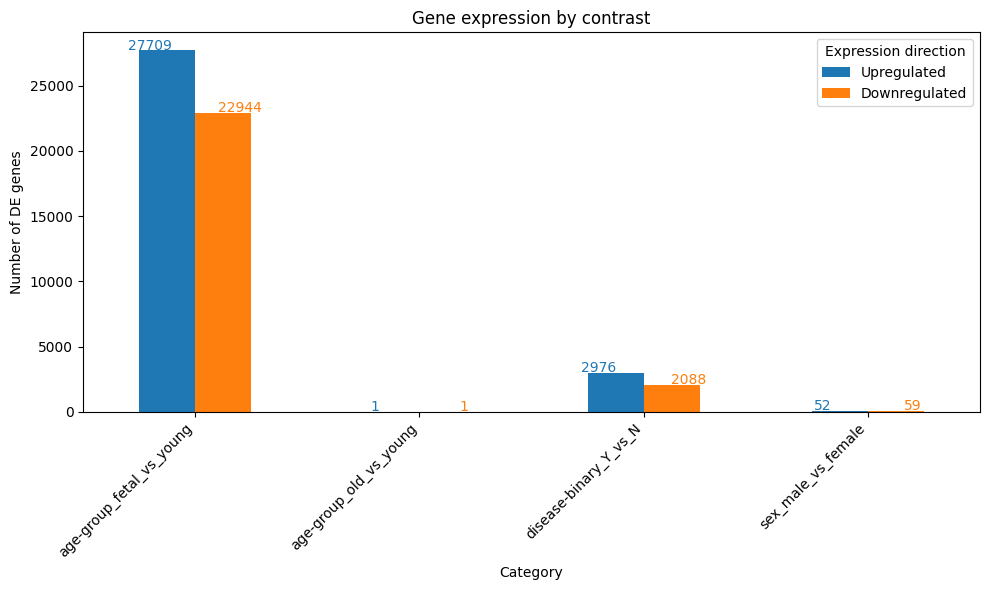

In [35]:
plot_DE_genes_barplot(significant_genes_dict = v1_significant_genes)

### Add technology as a covariate

In [36]:
%%time
v2_results_dict, v2_significant_genes, v2_dds = funcs.run_deseq_analysis(count_matrix, metadata, 
                                                                contrasts,
                                                                covariate_keys = ["technology", "sex", "age_group", "disease_binary"])

/home/william/anaconda3/envs/r-kernel/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/mnt/data1/william/human_heart_project/Final_manuscript_analysis/ATAC/aggregated_analysis/pseudobulked_analysis/run_pydeseq2_plots.py:118: UserWarning: Same factor names in the design contain underscores ('_'). They will
                be converted to hyphens ('-').
  dds = DeseqDataSet(
/home/william/anaconda3/envs/r-kernel/lib/python3.12/site-packages/pydeseq2/dds.py:264: UserWarning: Some factor levels in the design contain underscores ('_').
                    They will be converted to hyphens ('-').
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 1.37 seconds.

Fitting dispersions...
... done in 27.29 seconds.

Fitting dispersion trend curve...
/home/william/anaconda3/envs/r-kernel/lib/python3.12/site-packages/pyd

Log2 fold change & Wald test p-value: age-group fetal vs young
                         baseMean  log2FoldChange     lfcSE      stat  \
chr1:794224-794725       5.207113        0.265453  0.275893  0.962158   
chr1:794869-795370      16.681007       -0.235832  0.259822 -0.907671   
chr1:806996-807497       5.363628       -0.246067  0.348010 -0.707069   
chr1:807687-808188       5.803682        0.375351  0.331001  1.133988   
chr1:814556-815057       3.749195        0.574733  0.331974  1.731263   
...                           ...             ...       ...       ...   
chrY:20574903-20575404   4.683467       -0.149395  0.302735 -0.493484   
chrY:21702831-21703332   7.292253       -2.850700  0.455993 -6.251631   
chrY:21705255-21705756   4.760172       -2.165164  0.437585 -4.947985   
chrY:22123981-22124482   4.040439       -0.811436  0.480656 -1.688182   
chrY:22461930-22462431   4.200410       -0.888270  0.483874 -1.835747   

                              pvalue          padj  
chr1:79

Running Wald tests...
... done in 9.44 seconds.



Log2 fold change & Wald test p-value: age-group old vs young
                         baseMean  log2FoldChange     lfcSE      stat  \
chr1:794224-794725       5.207113       -0.265019  0.239810 -1.105119   
chr1:794869-795370      16.681007        0.177607  0.214792  0.826882   
chr1:806996-807497       5.363628        0.180286  0.276760  0.651415   
chr1:807687-808188       5.803682        0.081463  0.276439  0.294686   
chr1:814556-815057       3.749195        0.489904  0.282214  1.735929   
...                           ...             ...       ...       ...   
chrY:20574903-20575404   4.683467       -0.016663  0.237407 -0.070189   
chrY:21702831-21703332   7.292253        0.003553  0.270851  0.013118   
chrY:21705255-21705756   4.760172       -0.112905  0.250767 -0.450238   
chrY:22123981-22124482   4.040439        0.162344  0.321615  0.504779   
chrY:22461930-22462431   4.200410        0.094965  0.324523  0.292629   

                          pvalue      padj  
chr1:794224-79472

Running Wald tests...
... done in 9.41 seconds.



Log2 fold change & Wald test p-value: disease-binary Y vs N
                         baseMean  log2FoldChange     lfcSE      stat  \
chr1:794224-794725       5.207113        0.165526  0.354825  0.466500   
chr1:794869-795370      16.681007       -0.304217  0.302129 -1.006913   
chr1:806996-807497       5.363628        0.467674  0.491362  0.951791   
chr1:807687-808188       5.803682        0.918444  0.436753  2.102893   
chr1:814556-815057       3.749195        0.209390  0.467326  0.448060   
...                           ...             ...       ...       ...   
chrY:20574903-20575404   4.683467        0.071934  0.282202  0.254901   
chrY:21702831-21703332   7.292253       -0.142232  0.355235 -0.400387   
chrY:21705255-21705756   4.760172        0.165675  0.345918  0.478943   
chrY:22123981-22124482   4.040439        0.686294  0.588262  1.166646   
chrY:22461930-22462431   4.200410        0.696776  0.592906  1.175188   

                          pvalue      padj  
chr1:794224-794725

Running Wald tests...
... done in 9.71 seconds.



Log2 fold change & Wald test p-value: sex male vs female
                         baseMean  log2FoldChange     lfcSE      stat  \
chr1:794224-794725       5.207113       -0.007453  0.166908 -0.044653   
chr1:794869-795370      16.681007        0.071314  0.154645  0.461149   
chr1:806996-807497       5.363628       -0.029443  0.198505 -0.148323   
chr1:807687-808188       5.803682        0.165520  0.194416  0.851373   
chr1:814556-815057       3.749195       -0.020102  0.189197 -0.106247   
...                           ...             ...       ...       ...   
chrY:20574903-20575404   4.683467        2.612908  0.266835  9.792209   
chrY:21702831-21703332   7.292253        2.785684  0.294236  9.467518   
chrY:21705255-21705756   4.760172        2.417776  0.282408  8.561300   
chrY:22123981-22124482   4.040439        2.333266  0.313919  7.432711   
chrY:22461930-22462431   4.200410        2.359736  0.316828  7.448000   

                              pvalue          padj  
chr1:794224-7

<module 'matplotlib.pyplot' from '/home/william/anaconda3/envs/r-kernel/lib/python3.12/site-packages/matplotlib/pyplot.py'>

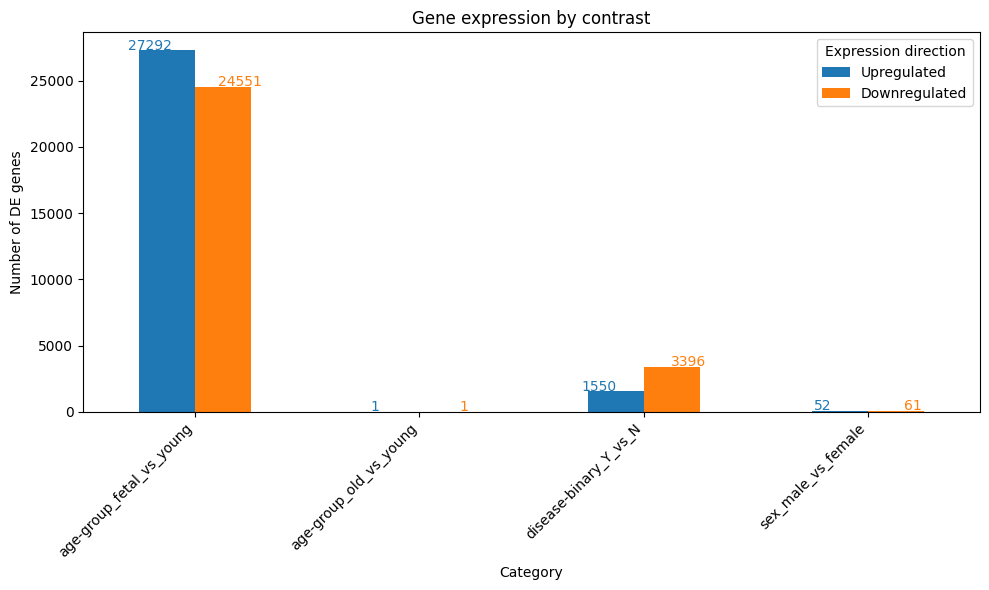

In [37]:
plot_DE_genes_barplot(significant_genes_dict = v2_significant_genes)

### Add study as a covariate

In [38]:
%%time
v3_results_dict, v3_significant_genes, v3_dds = funcs.run_deseq_analysis(count_matrix, metadata, 
                                                                contrasts,
                                                                covariate_keys = ["study", "sex", "age_group", "disease_binary"])

/home/william/anaconda3/envs/r-kernel/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/mnt/data1/william/human_heart_project/Final_manuscript_analysis/ATAC/aggregated_analysis/pseudobulked_analysis/run_pydeseq2_plots.py:118: UserWarning: Same factor names in the design contain underscores ('_'). They will
                be converted to hyphens ('-').
  dds = DeseqDataSet(
Fitting size factors...
... done in 1.33 seconds.

Fitting dispersions...
... done in 27.80 seconds.

Fitting dispersion trend curve...
/home/william/anaconda3/envs/r-kernel/lib/python3.12/site-packages/pydeseq2/dds.py:715: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 2.68 seconds.

Fitting MAP dispersions...
... done in 34.28 seconds.

Fitting LFCs...
...

Log2 fold change & Wald test p-value: age-group fetal vs young
                         baseMean  log2FoldChange     lfcSE      stat  \
chr1:794224-794725       5.207113        0.380090  0.267503  1.420880   
chr1:794869-795370      16.681007       -0.149063  0.241646 -0.616867   
chr1:806996-807497       5.363628       -0.243515  0.326675 -0.745435   
chr1:807687-808188       5.803682        0.411743  0.308499  1.334668   
chr1:814556-815057       3.749195        0.613063  0.316533  1.936803   
...                           ...             ...       ...       ...   
chrY:20574903-20575404   4.683467       -0.163477  0.314591 -0.519650   
chrY:21702831-21703332   7.292253       -2.848563  0.483175 -5.895505   
chrY:21705255-21705756   4.760172       -2.214255  0.465223 -4.759560   
chrY:22123981-22124482   4.040439       -1.005587  0.496182 -2.026650   
chrY:22461930-22462431   4.200410       -1.083191  0.499810 -2.167204   

                              pvalue          padj  
chr1:79

Running Wald tests...
... done in 8.14 seconds.



Log2 fold change & Wald test p-value: age-group old vs young
                         baseMean  log2FoldChange     lfcSE      stat  \
chr1:794224-794725       5.207113       -0.242052  0.233112 -1.038352   
chr1:794869-795370      16.681007        0.227809  0.196299  1.160520   
chr1:806996-807497       5.363628        0.239856  0.254870  0.941091   
chr1:807687-808188       5.803682        0.139093  0.255783  0.543794   
chr1:814556-815057       3.749195        0.541687  0.268292  2.019019   
...                           ...             ...       ...       ...   
chrY:20574903-20575404   4.683467        0.002246  0.239062  0.009394   
chrY:21702831-21703332   7.292253        0.052701  0.270762  0.194641   
chrY:21705255-21705756   4.760172       -0.077593  0.250096 -0.310253   
chrY:22123981-22124482   4.040439        0.195681  0.310226  0.630771   
chrY:22461930-22462431   4.200410        0.127619  0.313601  0.406945   

                          pvalue      padj  
chr1:794224-79472

Running Wald tests...
... done in 8.65 seconds.



Log2 fold change & Wald test p-value: disease-binary Y vs N
                         baseMean  log2FoldChange     lfcSE      stat  \
chr1:794224-794725       5.207113       -0.266637  0.546566 -0.487839   
chr1:794869-795370      16.681007       -0.592060  0.414829 -1.427237   
chr1:806996-807497       5.363628        0.054262  0.775607  0.069961   
chr1:807687-808188       5.803682        0.226748  0.670661  0.338096   
chr1:814556-815057       3.749195       -0.396661  0.711548 -0.557462   
...                           ...             ...       ...       ...   
chrY:20574903-20575404   4.683467        0.501476  0.471914  1.062643   
chrY:21702831-21703332   7.292253        0.115576  0.523224  0.220891   
chrY:21705255-21705756   4.760172        0.180980  0.530766  0.340979   
chrY:22123981-22124482   4.040439        0.055000  0.885509  0.062111   
chrY:22461930-22462431   4.200410        0.056751  0.892409  0.063593   

                          pvalue      padj  
chr1:794224-794725

Running Wald tests...
... done in 8.54 seconds.



Log2 fold change & Wald test p-value: sex male vs female
                         baseMean  log2FoldChange     lfcSE      stat  \
chr1:794224-794725       5.207113       -0.068065  0.163615 -0.416009   
chr1:794869-795370      16.681007        0.045767  0.142781  0.320536   
chr1:806996-807497       5.363628       -0.035542  0.183878 -0.193293   
chr1:807687-808188       5.803682        0.148985  0.180700  0.824486   
chr1:814556-815057       3.749195       -0.075515  0.179817 -0.419958   
...                           ...             ...       ...       ...   
chrY:20574903-20575404   4.683467        2.602432  0.272032  9.566647   
chrY:21702831-21703332   7.292253        2.745732  0.295429  9.294040   
chrY:21705255-21705756   4.760172        2.379271  0.283732  8.385634   
chrY:22123981-22124482   4.040439        2.329227  0.309241  7.532068   
chrY:22461930-22462431   4.200410        2.357546  0.312203  7.551333   

                              pvalue          padj  
chr1:794224-7

<module 'matplotlib.pyplot' from '/home/william/anaconda3/envs/r-kernel/lib/python3.12/site-packages/matplotlib/pyplot.py'>

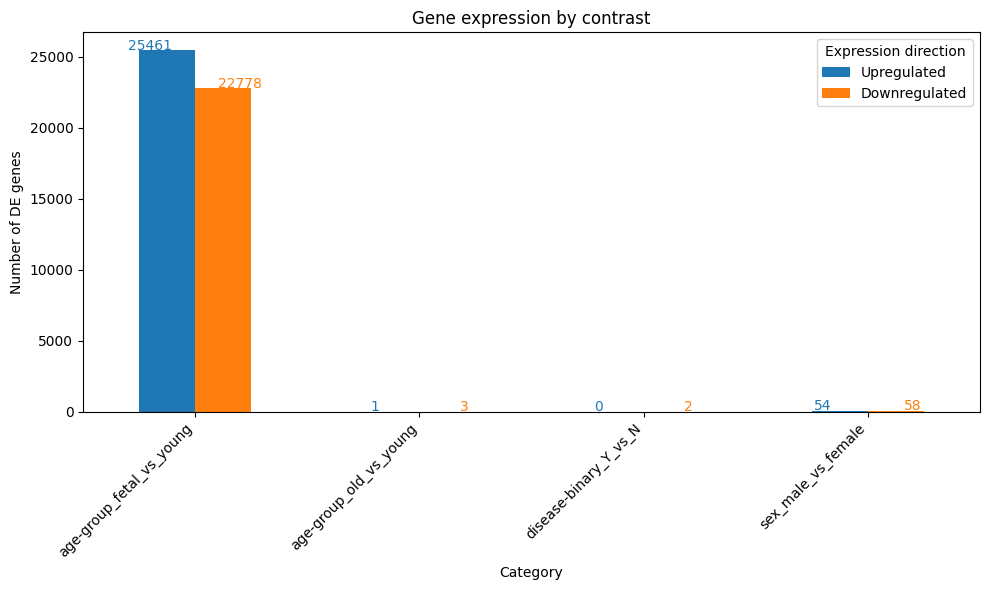

In [39]:
plot_DE_genes_barplot(significant_genes_dict = v3_significant_genes)

### Add technology + study as a covariate

In [40]:
%%time
v4_results_dict, v4_significant_genes, v4_dds = funcs.run_deseq_analysis(count_matrix, metadata, 
                                                                contrasts,
                                                                covariate_keys = ["tech_plus_study", "sex",
                                                                                  "age_group", "disease_binary"])

/home/william/anaconda3/envs/r-kernel/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/mnt/data1/william/human_heart_project/Final_manuscript_analysis/ATAC/aggregated_analysis/pseudobulked_analysis/run_pydeseq2_plots.py:118: UserWarning: Same factor names in the design contain underscores ('_'). They will
                be converted to hyphens ('-').
  dds = DeseqDataSet(
/home/william/anaconda3/envs/r-kernel/lib/python3.12/site-packages/pydeseq2/dds.py:264: UserWarning: Some factor levels in the design contain underscores ('_').
                    They will be converted to hyphens ('-').
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.89 seconds.

Fitting dispersions...
... done in 27.94 seconds.

Fitting dispersion trend curve...
/home/william/anaconda3/envs/r-kernel/lib/python3.12/site-packages/pyd

Log2 fold change & Wald test p-value: age-group fetal vs young
                         baseMean  log2FoldChange     lfcSE      stat  \
chr1:794224-794725       5.207113        0.380090  0.267502  1.420885   
chr1:794869-795370      16.681007       -0.149064  0.241648 -0.616867   
chr1:806996-807497       5.363628       -0.243513  0.326678 -0.745424   
chr1:807687-808188       5.803682        0.411744  0.308501  1.334659   
chr1:814556-815057       3.749195        0.613062  0.316530  1.936820   
...                           ...             ...       ...       ...   
chrY:20574903-20575404   4.683467       -0.163478  0.314590 -0.519652   
chrY:21702831-21703332   7.292253       -2.848545  0.483182 -5.895392   
chrY:21705255-21705756   4.760172       -2.214249  0.465226 -4.759517   
chrY:22123981-22124482   4.040439       -1.005573  0.496188 -2.026594   
chrY:22461930-22462431   4.200410       -1.083176  0.499817 -2.167144   

                              pvalue          padj  
chr1:79

Running Wald tests...
... done in 8.42 seconds.



Log2 fold change & Wald test p-value: age-group old vs young
                         baseMean  log2FoldChange     lfcSE      stat  \
chr1:794224-794725       5.207113       -0.242052  0.233111 -1.038355   
chr1:794869-795370      16.681007        0.227808  0.196300  1.160506   
chr1:806996-807497       5.363628        0.239854  0.254872  0.941079   
chr1:807687-808188       5.803682        0.139092  0.255785  0.543785   
chr1:814556-815057       3.749195        0.541687  0.268290  2.019039   
...                           ...             ...       ...       ...   
chrY:20574903-20575404   4.683467        0.002246  0.239061  0.009393   
chrY:21702831-21703332   7.292253        0.052701  0.270768  0.194636   
chrY:21705255-21705756   4.760172       -0.077592  0.250099 -0.310245   
chrY:22123981-22124482   4.040439        0.195681  0.310234  0.630754   
chrY:22461930-22462431   4.200410        0.127618  0.313609  0.406932   

                          pvalue      padj  
chr1:794224-79472

Running Wald tests...
... done in 8.92 seconds.



Log2 fold change & Wald test p-value: disease-binary Y vs N
                         baseMean  log2FoldChange     lfcSE      stat  \
chr1:794224-794725       5.207113       -0.266637  0.546566 -0.487841   
chr1:794869-795370      16.681007       -0.592060  0.414831 -1.427229   
chr1:806996-807497       5.363628        0.054265  0.775609  0.069964   
chr1:807687-808188       5.803682        0.226749  0.670664  0.338097   
chr1:814556-815057       3.749195       -0.396664  0.711545 -0.557469   
...                           ...             ...       ...       ...   
chrY:20574903-20575404   4.683467        0.501476  0.471914  1.062643   
chrY:21702831-21703332   7.292253        0.115579  0.523236  0.220892   
chrY:21705255-21705756   4.760172        0.180984  0.530772  0.340982   
chrY:22123981-22124482   4.040439        0.055003  0.885516  0.062114   
chrY:22461930-22462431   4.200410        0.056754  0.892417  0.063596   

                          pvalue      padj  
chr1:794224-794725

Running Wald tests...
... done in 9.41 seconds.



Log2 fold change & Wald test p-value: sex male vs female
                         baseMean  log2FoldChange     lfcSE      stat  \
chr1:794224-794725       5.207113       -0.068065  0.163614 -0.416006   
chr1:794869-795370      16.681007        0.045766  0.142783  0.320529   
chr1:806996-807497       5.363628       -0.035543  0.183879 -0.193297   
chr1:807687-808188       5.803682        0.148985  0.180702  0.824480   
chr1:814556-815057       3.749195       -0.075513  0.179815 -0.419947   
...                           ...             ...       ...       ...   
chrY:20574903-20575404   4.683467        2.602433  0.272032  9.566656   
chrY:21702831-21703332   7.292253        2.745721  0.295432  9.293909   
chrY:21705255-21705756   4.760172        2.379264  0.283733  8.385564   
chrY:22123981-22124482   4.040439        2.329213  0.309245  7.531935   
chrY:22461930-22462431   4.200410        2.357533  0.312206  7.551197   

                              pvalue          padj  
chr1:794224-7

<module 'matplotlib.pyplot' from '/home/william/anaconda3/envs/r-kernel/lib/python3.12/site-packages/matplotlib/pyplot.py'>

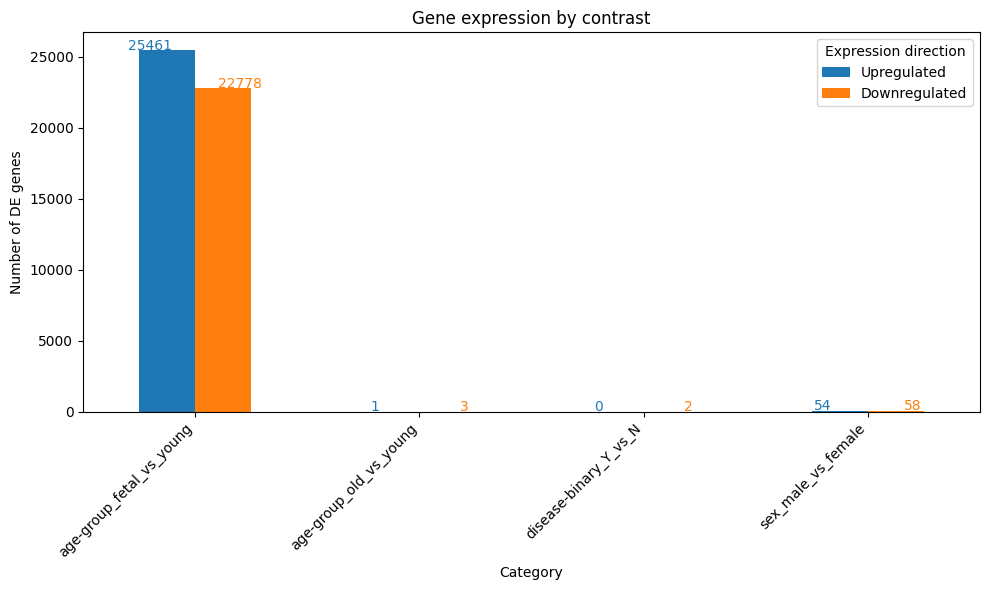

In [41]:
plot_DE_genes_barplot(significant_genes_dict = v4_significant_genes)

### Examine some DEGs

In [11]:
results_dict['disease-binary_Y_vs_N'].sort_values(by = "padj")

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_id
chr11:114246958-114247459,18.064605,2.262327,0.414838,5.453521,4.938211e-08,0.003403,chr11:114246958-114247459
chr5:153696195-153696696,17.624189,-1.739531,0.316125,-5.502670,3.740812e-08,0.003403,chr5:153696195-153696696
chr1:11856619-11857120,34.704182,4.181547,0.769783,5.432114,5.569047e-08,0.003403,chr1:11856619-11857120
chr18:48216882-48217383,100.145446,-1.112763,0.220812,-5.039413,4.669612e-07,0.012250,chr18:48216882-48217383
chr17:13393235-13393736,15.658502,-1.211630,0.243769,-4.970398,6.681549e-07,0.012250,chr17:13393235-13393736
...,...,...,...,...,...,...,...
chr18:61742982-61743483,17.323415,0.000033,0.349134,0.000094,9.999246e-01,0.999994,chr18:61742982-61743483
chr15:64163558-64164059,97.792814,0.000002,0.136814,0.000018,9.999858e-01,0.999994,chr15:64163558-64164059
chr3:62295503-62296004,17.789059,-0.000020,0.342376,-0.000058,9.999539e-01,0.999994,chr3:62295503-62296004
chr2:44087123-44087624,130.210862,0.000001,0.156421,0.000008,9.999936e-01,0.999994,chr2:44087123-44087624


In [12]:
# save the results_dict and dds as pickle objects
with open(results_dir +  cell_type + "_results_dict.pkl", "wb") as f:
    pickle.dump(results_dict, f)

with open(results_dir + cell_type + "_dds.pkl", "wb") as f:
    pickle.dump(dds, f)

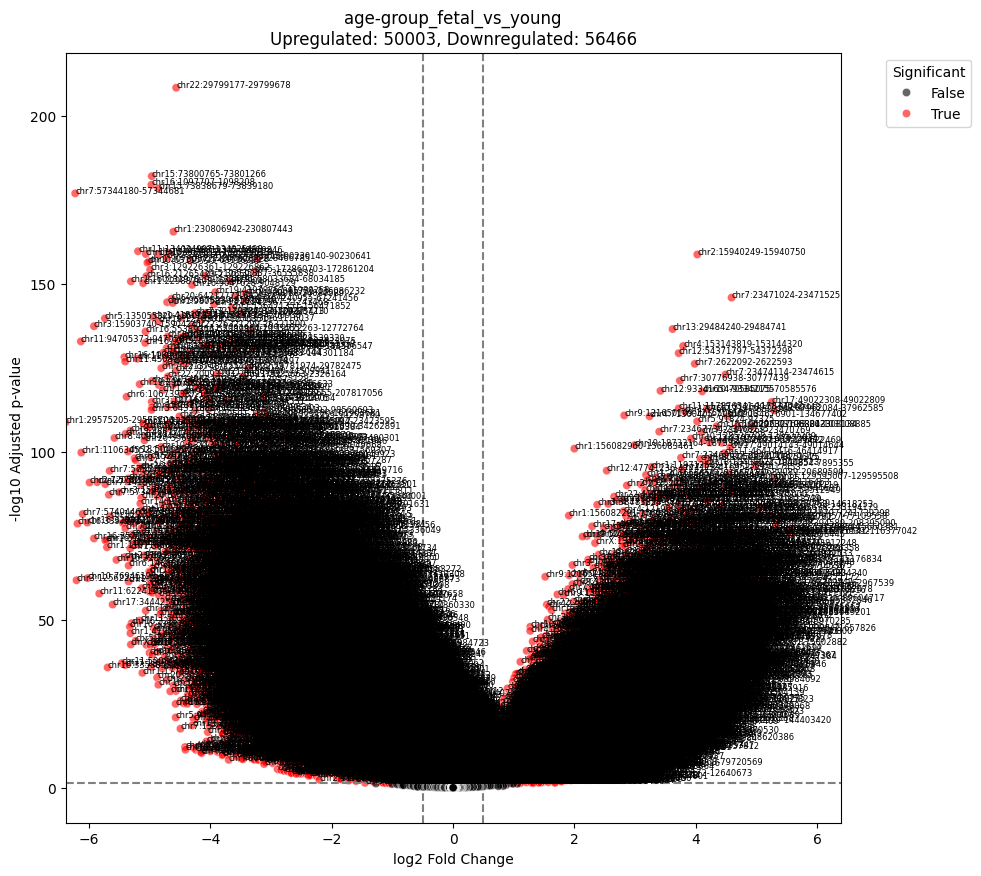

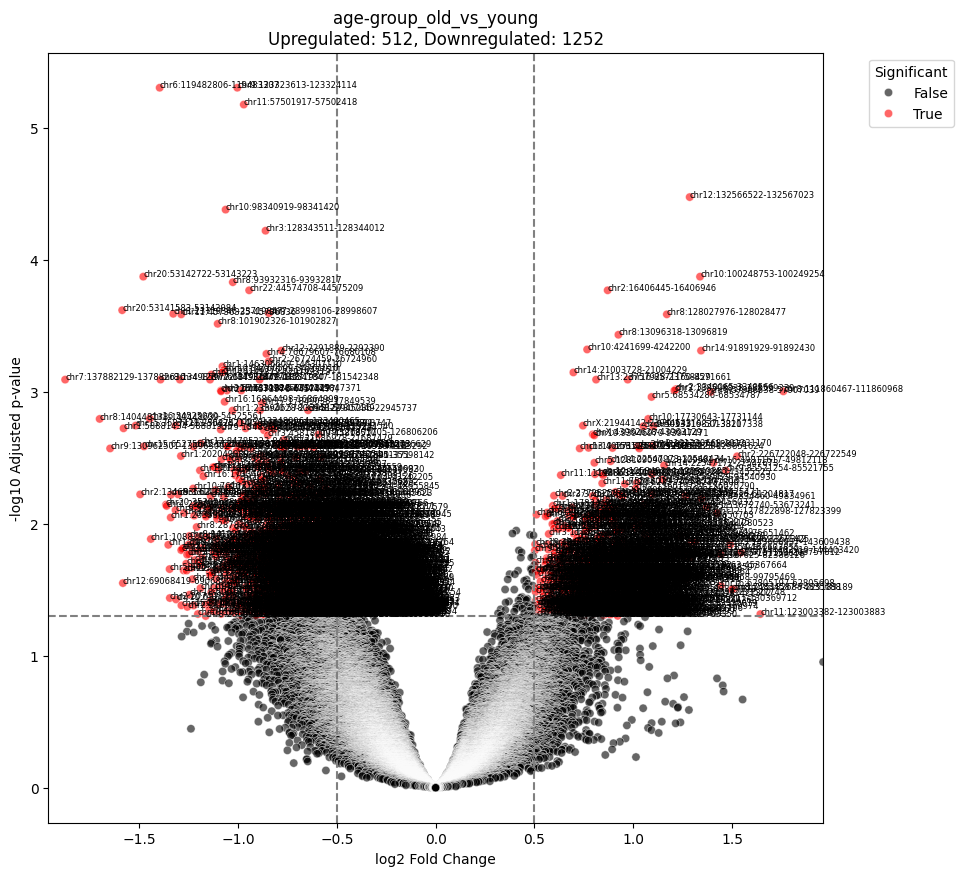

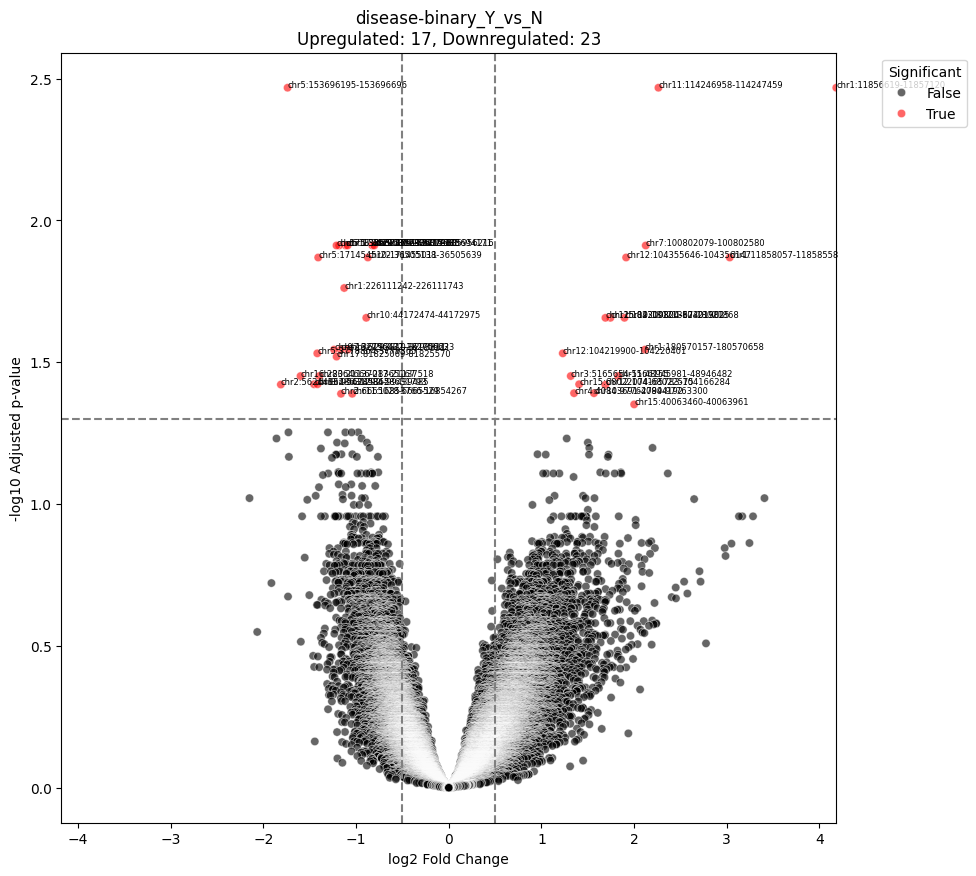

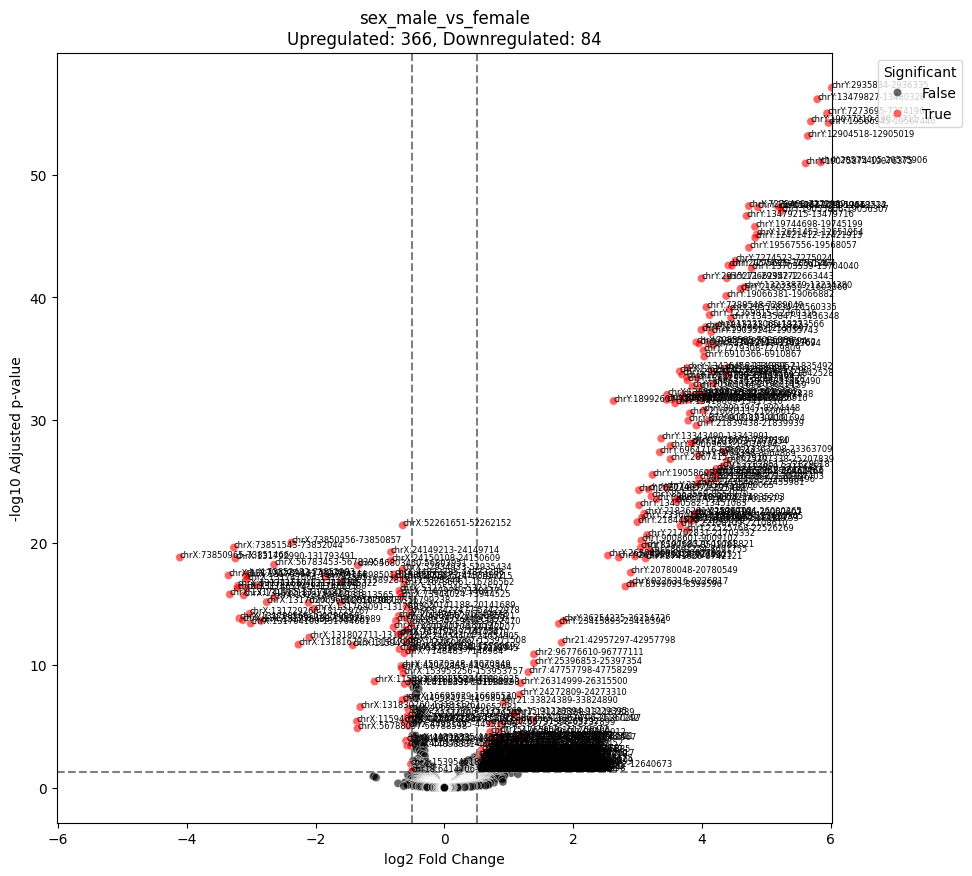

In [13]:
# produce volcano plots and save them
for contrast in contrasts:
    formatted_contrast = reformat_contrast_for_results_dict(contrast)

    # produce and save volcano plot
    contrast_plot = funcs.plot_volcano(results_dict[formatted_contrast], title = formatted_contrast)
    contrast_plot.savefig(plots_dir + cell_type + "_" + formatted_contrast + "_volcano_plot.pdf")

    # save the results for the contrast
    contrast_results_df = results_dict[formatted_contrast]
    contrast_results_df.to_csv(results_dir + cell_type + "_" + formatted_contrast + "_results.csv")

In [14]:
up_both, down_both, up_1_down_2, down_1_up_2, fetal_disease_consistent_ratio = funcs.analyze_gene_contrasts(results_dict, contrast1 = 'age-group_fetal_vs_young',  contrast2 = 'disease-binary_Y_vs_N',
                             plots_dir=plots_dir, cell_type=cell_type)

Up in contrast 1: 50003
Down in contrast 1: 23
Up in contrast 2: 17
Down in contrast 2: 23
Up in both age-group_fetal_vs_young and disease-binary_Y_vs_N: 4
Down in both age-group_fetal_vs_young and disease-binary_Y_vs_N: 8
Up in age-group_fetal_vs_young, down in disease-binary_Y_vs_N: 9
Down in age-group_fetal_vs_young, up in disease-binary_Y_vs_N: 12
Ratio of consistent change: 0.36363636363636365


<Figure size 755.556x444.444 with 0 Axes>

In [15]:
print(down_1_up_2)

12


In [16]:
results_dict['age-group_fetal_vs_young']

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_id,-log10(padj),significant
chr22:29799177-29799678,170.302520,-4.565515e+00,0.146136,-3.124151e+01,2.911097e-214,5.337031e-209,chr22:29799177-29799678,2.082727e+02,True
chr15:73800765-73801266,138.186405,-4.967584e+00,0.170031,-2.921573e+01,1.224060e-187,1.122059e-182,chr15:73800765-73801266,1.819500e+02,True
chr16:1097707-1098208,269.835320,-4.973767e+00,0.171513,-2.899936e+01,6.703439e-185,4.096561e-180,chr16:1097707-1098208,1.793876e+02,True
chr15:73838679-73839180,165.561420,-4.860215e+00,0.168147,-2.890459e+01,1.045412e-183,4.791489e-179,chr15:73838679-73839180,1.783195e+02,True
chr7:57344180-57344681,204.174739,-6.230125e+00,0.216481,-2.877912e+01,3.915102e-182,1.435543e-177,chr7:57344180-57344681,1.768430e+02,True
...,...,...,...,...,...,...,...,...,...
chr1:99481321-99481822,24.429184,1.900218e-05,0.153460,1.238251e-04,9.999012e-01,9.999230e-01,chr1:99481321-99481822,3.343402e-05,False
chr12:93247263-93247764,21.138517,1.702425e-05,0.173958,9.786433e-05,9.999219e-01,9.999368e-01,chr12:93247263-93247764,2.745918e-05,False
chr17:77535312-77535813,40.659800,-2.058383e-05,0.221540,-9.291252e-05,9.999259e-01,9.999368e-01,chr17:77535312-77535813,2.745918e-05,False
chr2:201781458-201781959,60.744453,-5.585875e-06,0.113489,-4.921942e-05,9.999607e-01,9.999662e-01,chr2:201781458-201781959,1.468682e-05,False


In [19]:
# perform fetal-disease overlap
up_both, down_both, up_1_down_2, down_1_up_2, fetal_disease_consistent_ratio = funcs.analyze_gene_contrasts(results_dict,
                                                                                        contrast1 = 'age-group_fetal_vs_young',
                                                                                        contrast2 = 'disease-binary_Y_vs_N',
                                                                                        plots_dir=plots_dir, cell_type=cell_type)

overlap_data = {"up_both": [up_both], "down_both": [down_both], "up_1_down_2": [up_1_down_2], "down_1_up_2": [down_1_up_2],
                "fetal_age_consistent_ratio": [fetal_disease_consistent_ratio]}
overlap_df = pd.DataFrame(overlap_data)
overlap_output_path = f"{plots_dir}/{cell_type}_fetal_disease_overlap_contrast_analysis.csv"
overlap_df.to_csv(overlap_output_path, index=False)

Up in contrast 1: 50003
Down in contrast 1: 23
Up in contrast 2: 17
Down in contrast 2: 23
Up in both age-group_fetal_vs_young and disease-binary_Y_vs_N: 4
Down in both age-group_fetal_vs_young and disease-binary_Y_vs_N: 8
Up in age-group_fetal_vs_young, down in disease-binary_Y_vs_N: 9
Down in age-group_fetal_vs_young, up in disease-binary_Y_vs_N: 12
Ratio of consistent change: 0.36363636363636365


<Figure size 755.556x444.444 with 0 Axes>

Mean (μ): 0.48129382846906
Standard Deviation (σ): 0.0992857108998393
Observed ratio of consistent change between the two contrasts (v): 0.36363636363636365
Z-score: -1.1850392545548745
P-value: 0.2360019267389879


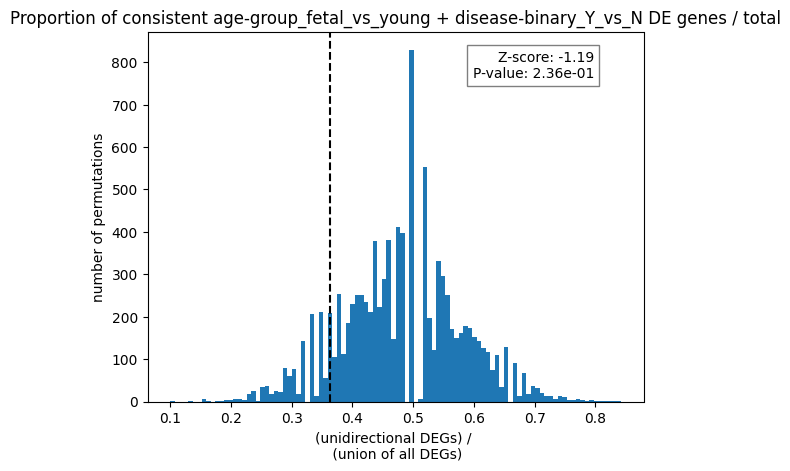

CPU times: user 9min 25s, sys: 3.5 s, total: 9min 29s
Wall time: 9min 30s


<Figure size 640x480 with 0 Axes>

In [21]:
%%time
# obtain z-value for the significance of the overlap
if all(var is not None for var in [up_both, down_both, up_1_down_2, down_1_up_2]):
    z_score_fetal, p_value, z_score_plt = funcs.run_simulations(count_matrix, significance_dict = significant_genes,
                                         obs_ratio_of_consistent_change = fetal_disease_consistent_ratio,
                                         contrast_1 = 'age-group_fetal_vs_young', contrast_2 = 'disease-binary_Y_vs_N',
                                         num_simulations = 10000, pseudocount = 1)
    z_score_plt.savefig(plots_dir + cell_type + "_disease_fetal_Z_score_simulation.pdf")

In [ ]:
%%time

# perform fetal-age overlap
up_both, down_both, up_1_down_2, down_1_up_2, fetal_age_consistent_ratio = funcs.analyze_gene_contrasts(results_dict,
                                                                                        contrast1 = 'age-group_fetal_vs_young',
                                                                                        contrast2 = 'age-group_old_vs_young',
                                                                                        plots_dir=plots_dir, cell_type=cell_type)

overlap_data = {"up_both": [up_both], "down_both": [down_both], "up_1_down_2": [up_1_down_2], "down_1_up_2": [down_1_up_2],
                    "fetal_age_consistent_ratio": [fetal_age_consistent_ratio]}
overlap_df = pd.DataFrame(overlap_data)
overlap_output_path = f"{plots_dir}/{cell_type}_fetal_age_overlap_contrast_analysis.csv"
overlap_df.to_csv(overlap_output_path, index=False)

# only run if all there are DEGs
if (up_both is not None) or (down_both is not None) or (up_1_down_2 is not None) or (down_1_up_2 is not None):
    # obtain z-value for the significance of the overlap
    z_score_age, p_value, z_score_plt = funcs.run_simulations(count_matrix, significance_dict = significant_genes,
                                         obs_ratio_of_consistent_change = fetal_age_consistent_ratio,
                                         contrast_1 = 'age-group_fetal_vs_young', contrast_2 = 'age-group_old_vs_young',
                                         num_simulations = 10000, pseudocount = 1)
    z_score_plt.savefig(plots_dir + cell_type + "_fetal_age_Z_score_simulation.pdf")
    cell_types_fetal_age.append(cell_type)
    Z_scores_fetal_age.append(z_score_age)

In [34]:
# also examine age + disease overlap
up_both, down_both, up_1_down_2, down_1_up_2, age_disease_consistent_ratio = funcs.analyze_gene_contrasts(results_dict,
                                                                                            contrast1 = 'age-group_old_vs_young',
                                                                                            contrast2 = 'disease-binary_Y_vs_N',
                                                                                            plots_dir=plots_dir,
                                                                                            cell_type=cell_type)

overlap_data = {"up_both": [up_both], "down_both": [down_both], "up_1_down_2": [up_1_down_2], "down_1_up_2": [down_1_up_2],
                    "age_disease_consistent_ratio": [age_disease_consistent_ratio]}
overlap_df = pd.DataFrame(overlap_data)
overlap_output_path = f"{plots_dir}/{cell_type}_age_disease_overlap_contrast_analysis.csv"
overlap_df.to_csv(overlap_output_path, index=False)

if (up_both is not None) or (down_both is not None) or (up_1_down_2 is not None) or (down_1_up_2 is not None):

    # obtain z-value for the significance of the overlap
    z_score_age, p_value, z_score_plt = funcs.run_simulations(count_matrix, significance_dict = significant_genes,
                                         obs_ratio_of_consistent_change = age_disease_consistent_ratio,
                                         contrast_1 = 'age-group_old_vs_young', contrast_2 = 'disease-binary_Y_vs_N',
                                         num_simulations = 10000, pseudocount = 1)

    z_score_plt.savefig(plots_dir + cell_type + "_disease_age_Z_score_simulation.pdf")
    cell_types_disease_age.append(cell_type)
    Z_scores_disease_age.append(z_score_age)    

                            baseMean  log2FoldChange     lfcSE          stat  \
chr22:29799177-29799678   170.302520   -4.565515e+00  0.146136 -3.124151e+01   
chr15:73800765-73801266   138.186405   -4.967584e+00  0.170031 -2.921573e+01   
chr16:1097707-1098208     269.835320   -4.973767e+00  0.171513 -2.899936e+01   
chr15:73838679-73839180   165.561420   -4.860215e+00  0.168147 -2.890459e+01   
chr7:57344180-57344681    204.174739   -6.230125e+00  0.216481 -2.877912e+01   
...                              ...             ...       ...           ...   
chr1:99481321-99481822     24.429184    1.900218e-05  0.153460  1.238251e-04   
chr12:93247263-93247764    21.138517    1.702425e-05  0.173958  9.786433e-05   
chr17:77535312-77535813    40.659800   -2.058383e-05  0.221540 -9.291252e-05   
chr2:201781458-201781959   60.744453   -5.585875e-06  0.113489 -4.921942e-05   
chr15:71447189-71447690    20.918314    8.677469e-08  0.177956  4.876192e-07   

                                 pvalue